In [ ]:
#@title Install requirements {display-mode: "form"}

# This code will be hidden when the notebook is loaded.
!pip install -U tensorboard-plugin-profile
!pip install torch 
!pip install transformers datasets
!pip install matplotlib pandas
!pip install torchinfo
!pip install latexify-py==0.2.0
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [ ]:
#@title Login to huggingface {display-mode: "form"}

# This code will be hidden when the notebook is loaded.
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
#@title Mount to Google Drive {display-mode: "form"}

# This code will be hidden when the notebook is loaded.
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


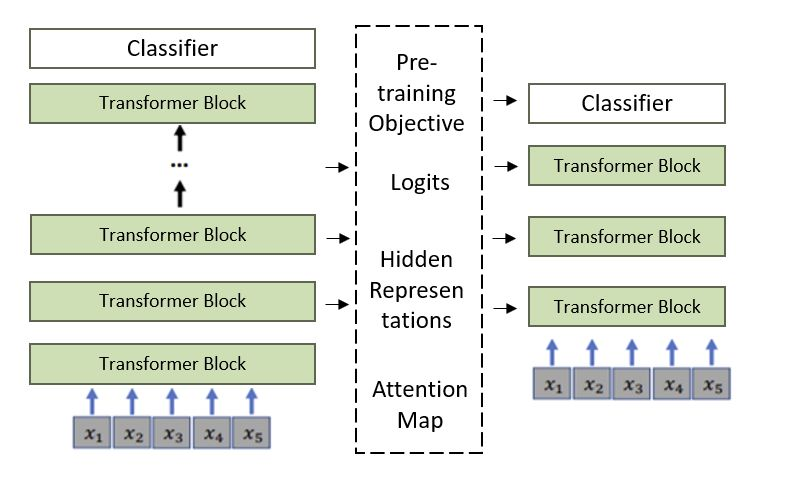

In [ ]:
#@title Task-specific Knowledge Distillation {display-mode: "form"}

# This code will be hidden when the notebook is loaded.
from IPython.display import Image
Image(filename='/content/gdrive/MyDrive/KnowledgeDistillation.jpg',width=1200,height=700)

# Knowledge Distillation as a form of Model Compression

Knowledge distillation is a general-purpose method to train a smaller student model to mimic the behavior of a slower, larger, but better performing teacher model, e.g. BERT as the teacher and DistilBERT as the student.

There are usually two types of knowledge distillation:
- Task-specific
- Task-agnostic

Task-specific knowledge distillation is used to fine-tune the model on a given dataset. The idea came from the [DistilBERT paper](https://arxiv.org/abs/1910.01108), as well as the [FastFormers paper](https://arxiv.org/abs/2010.13382), where it was shown to perform better than vanilla fine tuning an already distilled model.

# Teacher Model

Task-specific BERT-base-uncased fintuned on clinc dataset.

# Train task-specific teacher model (optional)

We can train the fine-tuned teacher parent from scratch or just use the pretrained one from huggingface.


# Teacher model


We're going to use a pretrained BERT-based-uncased finetuned on the clinc dataset. We will use transformers Pipelines, which combines tokenization, forward pass and backward pass. Pipelines can be setup for a specific task, such as text classification.

The teacher_id will be "transformersbook/bert-base-uncased-finetuned-clinc"

In [ ]:
from transformers import pipeline

# Load pretrained teacher model from huggingface
teacher_id = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=teacher_id)

In [ ]:
teacher_module = pipe.model
teacher_module

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
import torch
from torchinfo import summary 

teacher_module.to(torch.device("cpu"))
summary(teacher_module, dtypes=['torch.IntTensor'], device=torch.device("cpu"))

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           116,119
Total params: 

Test teacher model on sample query

In [ ]:
query = """Hey, I'd like to rent a vehicle from Aug 1st to Sept 15th in 
Seattle and I need a 15 passenger van"""
print(pipe(query))

[{'label': 'car_rental', 'score': 0.5592591762542725}]


## Clinc dataset

[Insert writeup and analysis, plots, etc]

In [ ]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
sample = clinc["test"][33]
print(f"Text | Intent = {sample}")

Text | Intent = {'text': 'i would like help moving money from one account to another', 'intent': 133}


### Clinc dataset Intents

In [ ]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

# Training procedure

## Training metrics
Accuracy 

In [ ]:
from datasets import load_metric 

accuracy_score = load_metric("accuracy")

<ipython-input-13-2ddb94fb810d>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy")


# Benchmarking Performance

To measure the performance improvements from knowledge distillation, we will benchmark our results. We will measure the following:
- Size of the model in megabytes (MB).
- Accuracy of the model.
- Average latency in milliseconds (ms). To report the average and std deviation we will conduct multiple trials measure the execution time of the forward pass (including tokenization since we are using a Pipeline).


We will record performanc metrics in a perf_metrics dictionary that we will update for each benchmarking run.

In [ ]:
from pathlib import Path
import numpy as np
import torch
from time import perf_counter

class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="teacher-bert"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
        
    def compute_accuracy(self):
      preds, labels = [], []
      for example in self.dataset:
          pred = self.pipeline(example["text"])[0]["label"]
          label = example["intent"]
          preds.append(intents.str2int(pred))
          labels.append(label)
      accuracy = accuracy_score.compute(predictions=preds, references=labels)
      print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
      return accuracy

    def compute_size(self):
        state_dict = self.pipeline.model.state_dict()
        tmp_path = Path(f"{self.optim_type}-model.pt")
        torch.save(state_dict, tmp_path)
        # Measure in megabytes
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        tmp_path.unlink()
        print(f"Model size (MB): {size_mb:.2f}")
        return {"size_mb" : size_mb}

    def time_pipeline(self, trials, query="What is the pin number for my account?"):
        latencies = []
        # warm up CPU/GPU
        for _ in range(10):
          _ = self.pipeline(query)
        # Run trials and record latency
        for _ in range(trials):
          start = perf_counter()
          _ = self.pipeline(query)
          latency = perf_counter() - start
          latencies.append(latency)
        # Get mean and std
        time_avg_ms = np.mean(latencies)*1000
        time_std_ms = np.std(latencies)*1000
        print(f"Average latency (ms): {time_avg_ms:.2f} +/- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}
    
    def run_benchmark(self, trials=100):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline(trials=trials))
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

## Benchmarking Teacher BERT base uncased fine-tuned model

In [ ]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB): 418.16
Average latency (ms): 156.01 +/- 42.98
Accuracy on test set - 0.867


# Teacher Model Baseline

- Model size (MB): `418.16`
- Average latency (ms): `73.72 +/- 8.10`
- Accuracy on test set - `0.867`

Writeup

# Knowledge Distillation (KD)

## KD Arguments

Knowledge distillation arguments
- alpha and temperature control the relative weight of the distillation loss and how much the probability distribution of the labels should be smoothed.

In [ ]:
from transformers import TrainingArguments

class KDArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [ ]:
#@title Knowledge Distillation Loss Function {display-mode: "form"}

# This code will be hidden when the notebook is loaded.
import latexify

@latexify.function
def KD_Loss(inputs, temperature, alpha,  student, teacher):
    # Extract cross-entropy loss and logits from student
    student_outputs = student(**inputs)
    loss_ce = student_outputs.loss
    student_logits = student_outputs.logits

    # Extract logits from teacher
    with torch.no_grad():
        teacher_outputs = teacher(**inputs)
        teacher_logits = teacher_outputs.logits

    # Soften probabilities and compute distillation loss
    loss_func = nn.KLDivLoss(reduction="batchmean")
    loss_kd = temperature ** 2 * loss_func(
        F.log_softmax(student_logits / temperature, dim=-1),
        F.softmax(teacher_logits / temperature, dim=-1))
    
    # Return weighted student loss
    loss = alpha * loss_ce + (1. - alpha) * loss_kd
    return loss
KD_Loss

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer


class KDTrainer(Trainer):
  def __init__(self, *args, teacher_model=None, **kwargs):
    super().__init__(*args, **kwargs)
    self.teacher_model = teacher_model
    # place teacher on same device as student
    self._move_model_to_device(self.teacher_model, self.model.device) 
    # Keep teacher in eval mode
    self.teacher_model.eval()
  
  # Overwrite compute_loss function of trainer
  def compute_loss(self, model, inputs, return_outputs=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # device found globally
    inputs = inputs.to(device)

    student_outputs = model(**inputs)
    # Extract cross-entropy loss and logits from student
    loss_ce = student_outputs.loss
    student_logits = student_outputs.logits

    # Extract logits from teacher
    with torch.no_grad():
        teacher_outputs = self.teacher_model(**inputs)
        teacher_logits = teacher_outputs.logits

    # Soften probabilities and compute distillation loss
    loss_func = nn.KLDivLoss(reduction="batchmean")
    loss_kd = self.args.temperature ** 2 * loss_func(
        F.log_softmax(student_logits / self.args.temperature, dim=-1),
        F.softmax(teacher_logits / self.args.temperature, dim=-1))
    
    # Return weighted student loss
    loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
    return (loss, student_outputs) if return_outputs else loss


# Choosing a student model

Choose a student model that is similar to the teacher but smaller. E.g., We are using BERT as the parent model, so we can use DistilBERT as the student model.

# Preprocess data

In [ ]:
from transformers import AutoTokenizer

student_id = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_id)

def tokenize_batch(batch):
  return student_tokenizer(batch["text"], truncation=True)

clinc_encoded = clinc.map(tokenize_batch, batched=True, remove_columns=['text'])
clinc_encoded = clinc_encoded.rename_column("intent", "labels")

  0%|          | 0/6 [00:00<?, ?ba/s]

In [ ]:
def compute_metrics(pred):
  predictions, labels = pred
  predictions = np.argmax(predictions, axis=1)
  return accuracy_score.compute(predictions=predictions, references=labels)

In [ ]:
batch_size = 48

finetuned_id = "kd-distilBERT-clinc"
student_training_args = KDArguments(
    output_dir=finetuned_id,
    evaluation_strategy="epoch",
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    alpha=1,
    weight_decay=0.01,
    push_to_hub=True,
)
student_training_args.logging_steps = len(clinc_encoded['train']) // batch_size
student_training_args.disable_tqdm = False
student_training_args.save_steps = 1e9

Student model needs mapping from intent to label, etc.

In [ ]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id
num_labels = intents.num_classes

# Load teacher checkpoint w/o tokenizer

In [ ]:
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding

# define data_collator
data_collator = DataCollatorWithPadding(tokenizer=student_tokenizer)

# Define teacher model
teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id,
    num_labels=num_labels, 
    id2label=id2label,
    label2id=label2id,
)

# Define student model
student_model = AutoModelForSequenceClassification.from_pretrained(
    student_id,
    num_labels=num_labels, 
    id2label=id2label,
    label2id=label2id,
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--transformersbook--bert-base-uncased-finetuned-clinc/snapshots/795b076da71dc236dde692338e21560cbbffa6e4/config.json
Model config BertConfig {
  "_name_or_path": "transformersbook/bert-base-uncased-finetuned-clinc",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "restaurant_reviews",
    "1": "nutrition_info",
    "2": "account_blocked",
    "3": "oil_change_how",
    "4": "time",
    "5": "weather",
    "6": "redeem_rewards",
    "7": "interest_rate",
    "8": "gas_type",
    "9": "accept_reservations",
    "10": "smart_home",
    "11": "user_name",
    "12": "report_lost_card",
    "13": "repeat",
    "14": "whisper_mode",
    "15": "what_are_your_hobbies",
    "16": "order",
    "

In [ ]:
distilbert_trainer = KDTrainer(
    student_model,
    student_training_args,
    teacher_model=teacher_model,
    train_dataset=clinc_encoded['train'], 
    eval_dataset=clinc_encoded['validation'],
    data_collator=data_collator,
    tokenizer=student_tokenizer,
    compute_metrics=compute_metrics,
  )

Cloning https://huggingface.co/wmduggan41/kd-distilBERT-clinc into local empty directory.


Download file pytorch_model.bin:   0%|          | 15.4k/256M [00:00<?, ?B/s]

Download file runs/Dec03_03-40-59_8e942cb4897a/events.out.tfevents.1670040043.8e942cb4897a.76.0: 100%|########…

Download file runs/Dec05_19-19-35_0d85ad4a5bf5/events.out.tfevents.1670268980.0d85ad4a5bf5.75.0:  25%|##5     …

Download file runs/Dec03_06-30-53_8e942cb4897a/events.out.tfevents.1670049063.8e942cb4897a.2679.0:  11%|#     …

Download file runs/Nov21_20-50-18_4bb995089ff8/events.out.tfevents.1669064483.4bb995089ff8.107.0: 100%|#######…

Download file runs/Dec03_06-30-53_8e942cb4897a/1670049063.5893927/events.out.tfevents.1670049063.8e942cb4897a.…

Download file runs/Dec05_19-19-35_0d85ad4a5bf5/1670268980.2724268/events.out.tfevents.1670268980.0d85ad4a5bf5.…

Download file runs/Dec03_03-40-59_8e942cb4897a/events.out.tfevents.1670040554.8e942cb4897a.76.2: 100%|########…

Download file runs/Dec03_03-40-59_8e942cb4897a/1670040043.9152486/events.out.tfevents.1670040043.8e942cb4897a.…

Download file training_args.bin: 100%|##########| 3.36k/3.36k [00:00<?, ?B/s]

Download file runs/Nov21_20-50-18_4bb995089ff8/1669064483.1971285/events.out.tfevents.1669064483.4bb995089ff8.…

Clean file runs/Dec03_03-40-59_8e942cb4897a/events.out.tfevents.1670040043.8e942cb4897a.76.0:   7%|7         |…

Download file runs/Dec03_03-40-59_8e942cb4897a/1670040554.4345083/events.out.tfevents.1670040554.8e942cb4897a.…

Clean file runs/Nov21_20-50-18_4bb995089ff8/events.out.tfevents.1669064483.4bb995089ff8.107.0:   7%|7         …

Clean file runs/Dec03_06-30-53_8e942cb4897a/1670049063.5893927/events.out.tfevents.1670049063.8e942cb4897a.267…

Clean file runs/Dec03_03-40-59_8e942cb4897a/events.out.tfevents.1670040554.8e942cb4897a.76.2:   7%|7         |…

Clean file runs/Dec03_06-30-53_8e942cb4897a/events.out.tfevents.1670049063.8e942cb4897a.2679.0:   7%|7        …

Clean file runs/Dec03_03-40-59_8e942cb4897a/1670040043.9152486/events.out.tfevents.1670040043.8e942cb4897a.76.…

Clean file runs/Dec05_19-19-35_0d85ad4a5bf5/events.out.tfevents.1670268980.0d85ad4a5bf5.75.0:   7%|7         |…

Clean file runs/Dec05_19-19-35_0d85ad4a5bf5/1670268980.2724268/events.out.tfevents.1670268980.0d85ad4a5bf5.75.…

Clean file training_args.bin:  30%|##9       | 1.00k/3.36k [00:00<?, ?B/s]

Clean file runs/Nov21_20-50-18_4bb995089ff8/1669064483.1971285/events.out.tfevents.1669064483.4bb995089ff8.107…

Clean file runs/Dec03_03-40-59_8e942cb4897a/1670040554.4345083/events.out.tfevents.1670040554.8e942cb4897a.76.…

Clean file pytorch_model.bin:   0%|          | 1.00k/256M [00:00<?, ?B/s]

# Training task-specific distilbert student model

In [ ]:
print(distilbert_trainer.train())

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 15250
  Num Epochs = 5
  Instantaneous batch size per device = 48
  Total train batch size (w. parallel, distributed & accumulation) = 48
  Gradient Accumulation steps = 1
  Total optimization steps = 1590
  Number of trainable parameters = 67069591
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,4.273100,3.265356,0.722258
2,2.610900,1.868551,0.845806
3,1.535600,1.153278,0.889355
4,1.005400,0.858938,0.910000
5,0.794500,0.775162,0.915161


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1590, training_loss=2.039809664240423, metrics={'train_runtime': 14343.4999, 'train_samples_per_second': 5.316, 'train_steps_per_second': 0.111, 'total_flos': 413463652747656.0, 'train_loss': 2.039809664240423, 'epoch': 5.0})


In [ ]:
print(distilbert_trainer.push_to_hub("Task-specific fine-tuning complete!"))

# [Hugging_Face](https://huggingface.co/wmduggan41/kd-distilBERT-clinc?text=I+like+you.+I+love+you)

In [ ]:
# Pull fine-tuned distilled model from hub
student_pipe = pipeline("text-classification", model=finetuned_id)
student_module = student_pipe.model
print(student_module)

loading configuration file kd-distilBERT-clinc/config.json
Model config DistilBertConfig {
  "_name_or_path": "kd-distilBERT-clinc",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "restaurant_reviews",
    "1": "nutrition_info",
    "2": "account_blocked",
    "3": "oil_change_how",
    "4": "time",
    "5": "weather",
    "6": "redeem_rewards",
    "7": "interest_rate",
    "8": "gas_type",
    "9": "accept_reservations",
    "10": "smart_home",
    "11": "user_name",
    "12": "report_lost_card",
    "13": "repeat",
    "14": "whisper_mode",
    "15": "what_are_your_hobbies",
    "16": "order",
    "17": "jump_start",
    "18": "schedule_meeting",
    "19": "meeting_schedule",
    "20": "freeze_account",
    "21": "what_song",
    "22": "meaning_of_life",
    "23": "restaurant_reservation",
    "24": "traffic",
    "25": "make_call",


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

## Model summary for student model

In [ ]:
student_module.to(torch.device("cpu"))
summary(student_module, dtypes=['toch.IntTensor'], device=torch.device("cpu"))

# Benchmarking distilled student fine-tuned model

In [ ]:
optim_type = "kd-DistilBERT"
pb = PerformanceBenchmark(
    student_pipe, 
    clinc["test"], 
    optim_type=optim_type,
)
perf_metrics.update(pb.run_benchmark())

Model size (MB): 255.89
Average latency (ms): 43.23 +/- 1.82
Accuracy on test set - 0.853


# Student model 
- Model size (MB): `255.89`
- Average latency (ms): `13.53 +/- 1.55`
- Accuracy on test set - `0.859`

# Analysis



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        alpha=0.5, s=df_opt["size_mb"], label=idx, 
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        s=df_opt["size_mb"], label=idx, alpha=0.5)
            
    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["teacher-bert"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()
    
plot_metrics(perf_metrics, 'kd-DistilBERT')

In [ ]:
pd.DataFrame.from_dict(perf_metrics, orient='index')

This model is a fine-tuned version of [distilbert-base-uncased](https://huggingface.co/distilbert-base-uncased) on the clinc_oos dataset.
It achieves the following results on the evaluation set:
- Loss: 0.7533
- Accuracy: 0.9235

In [ ]:
@misc {william_m_duggan_2022, 
	author       = { {William M Duggan} },
	title        = { kd-distilBERT-clinc (Revision 6bc3b2b) },
	year         = 2022,
	url          = { https://huggingface.co/wmduggan41/kd-distilBERT-clinc },
	doi          = { 10.57967/hf/0171 },
	publisher    = { Hugging Face }
}

SyntaxError: ignored